In [1]:
import os
import copy
import glob
import subprocess
import h5py
import slug

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sep

import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column, vstack
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.coordinates import SkyCoord


from kungpao.display import display_single, IMG_CMAP, SEG_CMAP
from kungpao import imtools

from tractor import NullWCS, NullPhotoCal, ConstantSky
from tractor.galaxy import GalaxyShape, DevGalaxy, ExpGalaxy
from tractor.psf import Flux, PixPos, PointSource, PixelizedPSF, Image, Tractor
from tractor.ellipses import EllipseE


%matplotlib inline

## Import image file

In [ ]:
band = 'r-band'

In [2]:
# Login NAOJ server
slug.login_naoj_server('/Users/jiaxuanli/Documents/HSC_config')

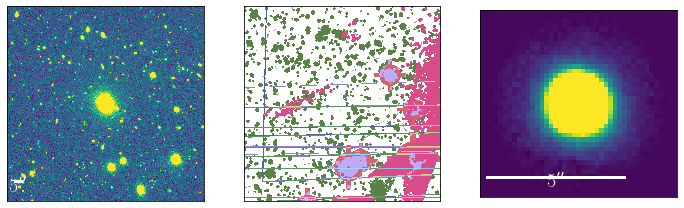

In [85]:
f = h5py.File('./HDF5/RealMockGalaxy-000.h5', 'r+')

# Image
img_data = f['MockImage'][band]['model-0/mockimage'].value
w = WCS(f['Background'][band]['image_header'].value)
mask = f['Background'][band]['mask'].value
variance = f['Background'][band]['variance'].value
invvar = (1.0/(variance**2.0))

# Construct PSF
psf_data = f['Background'][band]['PSF'].value
psf_obj = PixelizedPSF(psf_data, Lorder=3)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0] = display_single(img_data, ax=ax[0])
ax[1] = display_single(mask, ax=ax[1], scale='linear', cmap=SEG_CMAP)
ax[2] = display_single(psf_data, ax=ax[2])

# Extract objects using `sep`
objects, segmap = slug.extract_obj(img_data, sigma=3)
bright_mask = slug.make_HSC_bright_obj_mask(mask, objects, segmap)
img_data = img_data*(~bright_mask)
obj_table, segmap = slug.extract_obj(img_data, sigma=3)

# Generate manual measurement table
pixel_scale = slug.HSC_pixel_scale
a_arcsec, b_arcsec = (pixel_scale * obj_table['a']), (pixel_scale * obj_table['b']) # arcsec
x = obj_table['x']
y = obj_table['y']
ra, dec = w.wcs_pix2world(zip(x,y),1).T
x2 = obj_table['x2']
y2 = obj_table['y2']
xy = obj_table['xy']
a = obj_table['a'] # pixel
b = obj_table['b'] # pixel
theta = obj_table['theta']
flux = obj_table['flux']
point_source = [((b_arcsec[i]/ a_arcsec[i] > .9) and (a_arcsec[i]<.35)) for i in range(len(obj_table))]
t = Table([ra, dec, x, y, x2, y2, xy, a, b, a_arcsec, b_arcsec, theta, flux, point_source], 
          names=('ra', 'dec', 'x', 'y', 'x2','y2','xy', 'a', 'b', 
                 'a_arcsec','b_arcsec','theta','flux','point_source'), 
          meta={'name': 'object table'})

# Download DECaLS tractor catalogs automatically

In [73]:
bricks_cat = Table.read('./survey-bricks-dr7.fits', format='fits')
bricks_sky = SkyCoord(ra=np.array(bricks_cat['ra'])*u.degree, dec=np.array(bricks_cat['dec'])*u.degree)
measure_catalog = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)

to_download = bricks_cat[np.unique(match_coordinates_sky(measure_catalog, bricks_sky)[0])]
def gen_url_decals_tractor(brickname):
    return [
        'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr7/tractor/'
        + brickname[:3] + '/tractor-' + brickname + '.fits'
    ]


<Table length=1>
brickname         ra           dec   ...    ext_w2       ext_w3        ext_w4   
   str8        float64       float64 ...   float32      float32       float32   
--------- ------------------ ------- ... ----------- ------------- -------------
 2355p345 235.51260504201682    34.5 ... 0.003161392 0.00067427993 0.00025461835

In [74]:
def gen_url_decals_tractor(brickname):
    return [
        'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr7/tractor/'
        + brickname[:3] + '/tractor-' + brickname + '.fits'
    ]

In [75]:
bricknames = [tt['brickname'] for tt in to_download]
url_set = [gen_url_decals_tractor(tt)[0] for tt in bricknames]
decals_cat = vstack([Table.read(url) for url in url_set])

### Match these galaxies with DECaLS tractor file and get their type

In [76]:
decals_catalog = SkyCoord(ra=np.array(decals_cat['ra'])*u.degree, dec=np.array(decals_cat['dec'])*u.degree)
measure_catalog = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)

temp = decals_cat[match_coordinates_sky(measure_catalog, decals_catalog)[0]]

In [77]:
for columns in temp.columns:
    t.add_column(temp[columns], rename_duplicate=True)
obj_cat = t
obj_cat.sort('flux')
obj_cat.reverse()

In [78]:
mag_mask = 27-2.5*np.log10(obj_cat['flux'])<20
type_mask = (obj_cat['type']=='PSF ')
for i in np.argwhere(mag_mask & type_mask):
    obj_cat[int(i[0])]['type'] = 'DEV '
obj_cat[0]['type'] = 'COMP'

## Run tractor recursively

Now you have 99 sources


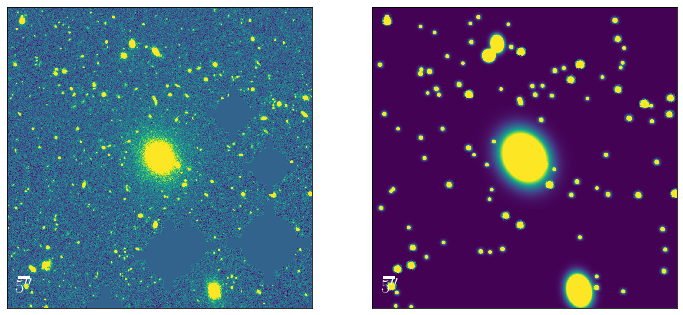

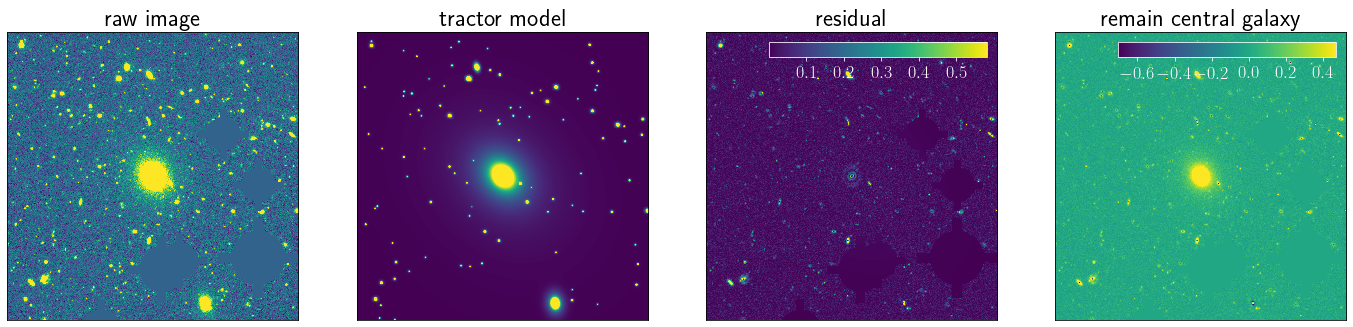

('The chi-square is', 0.16494948)
Now you have 198 sources


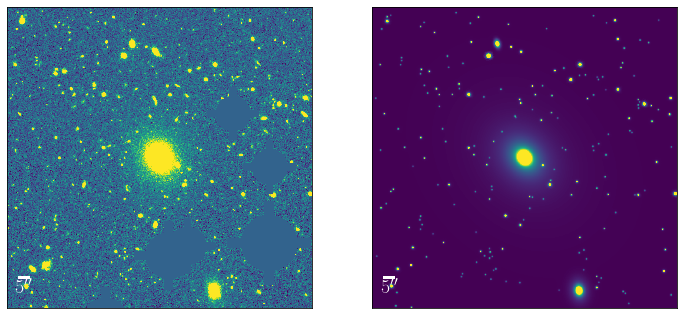

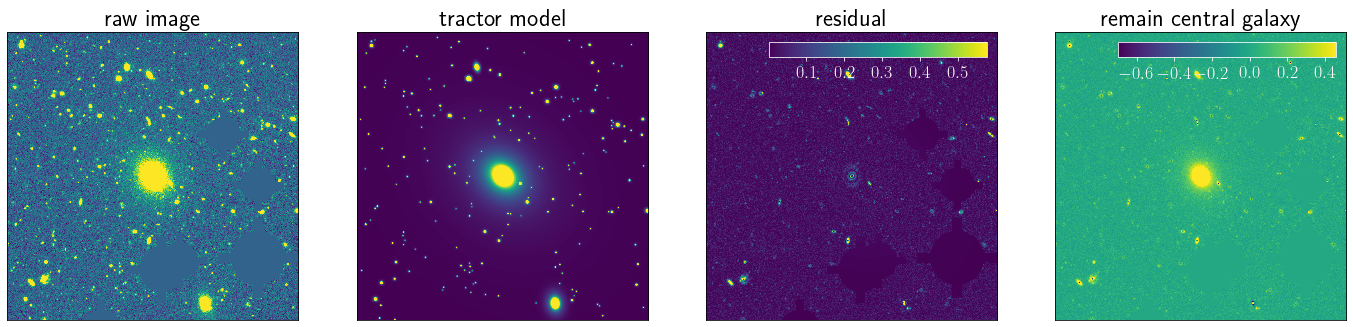

('The chi-square is', 0.16430461)
Now you have 297 sources


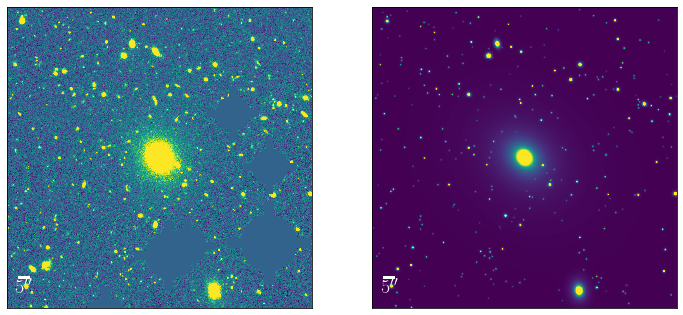

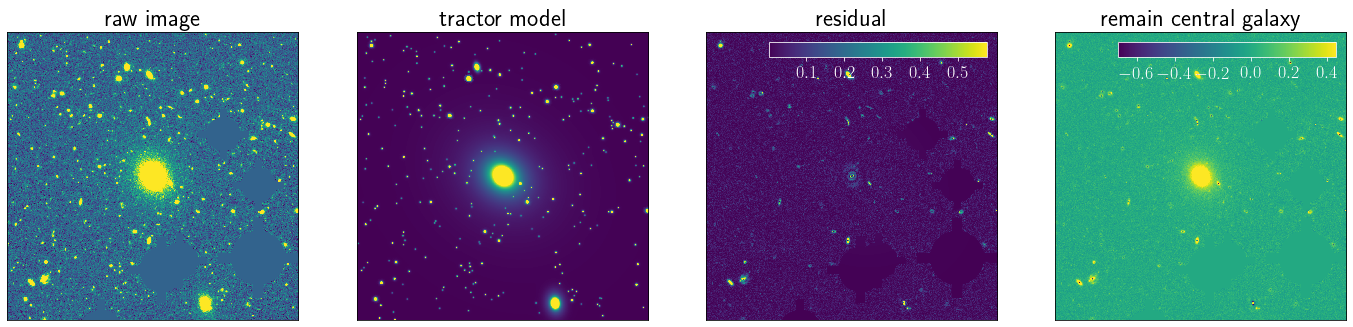

('The chi-square is', 0.1640397)
Now you have 396 sources


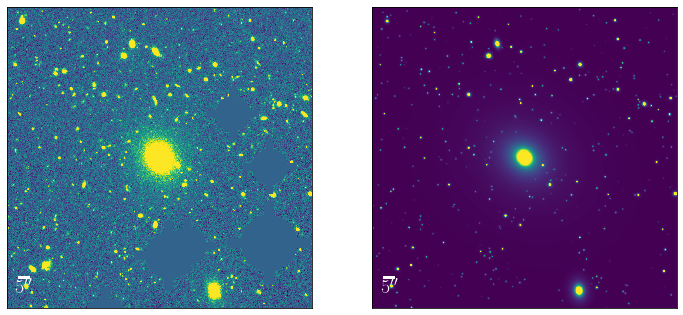

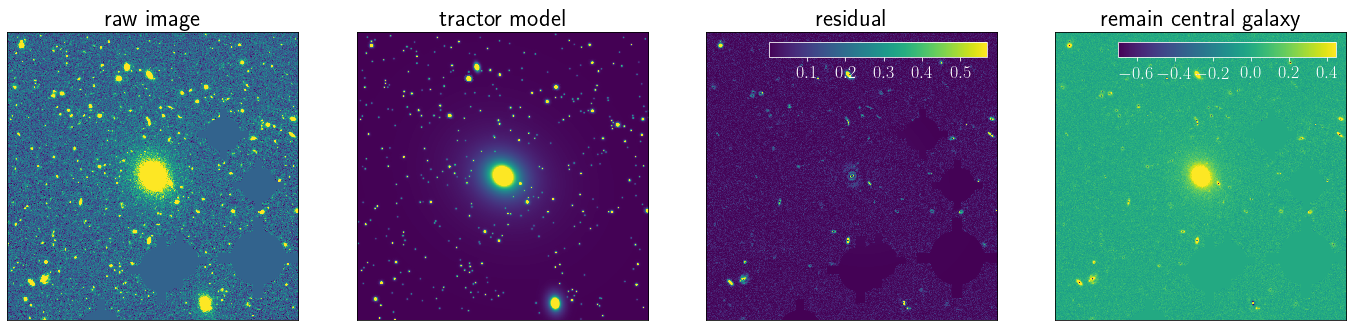

('The chi-square is', 0.16395082)


In [80]:
kfold = 4
step = int(len(obj_cat)/4)
for i in range(kfold):
    obj_small_cat = obj_cat[step*i:step*(i+1)]
    if i == 0:
        sources = slug.add_tractor_sources(obj_small_cat, None, w, shape_method='manual')
    else:
        sources = slug.add_tractor_sources(obj_small_cat, sources, w, shape_method='manual')
    tim = Image(data=img_data,
                invvar=invvar,
                psf=psf_obj,
                wcs=NullWCS(pixscale=slug.HSC_pixel_scale),
                sky=ConstantSky(0.0),
                photocal=NullPhotoCal()
                )
    trac_obj = Tractor([tim], sources)
    trac_mod = trac_obj.getModelImage(0, minsb=0.0)

    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))
    ax1 = display_single(img_data, ax=ax1)
    ax2 = display_single(trac_mod, ax=ax2, contrast=0.01)
    plt.show(block=False)
    
    trac_obj.freezeParam('images')
    trac_obj.optimize_loop()
    ########################
    
    plt.rc('font', size=20)
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(24,8))
    
    trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources[:])

    ax1 = display_single(img_data, ax=ax1, scale_bar=False)
    ax1.set_title('raw image')
    ax2 = display_single(trac_mod_opt, ax=ax2, scale_bar=False, contrast=0.02)
    ax2.set_title('tractor model')
    ax3 = display_single(abs(img_data - trac_mod_opt), ax=ax3, scale_bar=False, color_bar=True, contrast=0.05)
    ax3.set_title('residual')

    trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources[1:])

    ax4 = display_single(img_data - trac_mod_opt, ax=ax4, scale_bar=False, color_bar=True, contrast=0.05)
    ax4.set_title('remain central galaxy')
    if i == (kfold-1):
        plt.savefig('./tractor_midz.png', dpi=200, bbox_inches='tight')
    plt.show(block=False)
    print('The chi-square is', np.sqrt(np.mean(np.square((img_data - trac_mod_opt).flatten()))))

In [87]:
f['MockImage'][band]['model-0'].create_dataset('TractorSubtracted', data=img_data - trac_mod_opt)
f.close()

<HDF5 dataset "TractorSubtracted": shape (995, 1007), type "<f4">